In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from xgboost import XGBClassifier

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
full_df = pd.concat([train_df, test_df], axis=0)

In [3]:
y = train_df.Survived

In [4]:
full_df['IsAlone'] = (full_df['SibSp'] + full_df['Parch'] == 0) * 1
full_df['Salut'] = [ extract_salut(name) for full_df['Name']]
ages = full_df.groupby(['Sex', 'Pclass', 'IsAlone']).Age.median()
ages

Sex     Pclass  IsAlone
female  1       0          37.0
                1          35.0
        2       0          24.5
                1          30.0
        3       0          20.5
                1          22.0
male    1       0          39.0
                1          42.0
        2       0          29.0
                1          30.0
        3       0          17.0
                1          26.0
Name: Age, dtype: float64

In [5]:
fares = full_df.groupby(['Pclass', 'Embarked']).Fare.median()
fares

Pclass  Embarked
1       C           76.7292
        Q           90.0000
        S           52.0000
2       C           15.3146
        Q           12.3500
        S           15.3750
3       C            7.8958
        Q            7.7500
        S            8.0500
Name: Fare, dtype: float64

In [6]:
def prep(df):
    X = pd.DataFrame((df['Sex'] == 'female') * 1)
    df['IsAlone'] = (df['SibSp'] + df['Parch'] == 0) * 1
    X['IsAlone'] = df['IsAlone']

    ages_default = df.apply(lambda s: ages[s['Sex'], s['Pclass'], s['IsAlone']], axis=1)
    ages_complete = df.Age.fillna(ages_default).astype(int)
    X['Age'] = ages_complete - (ages_complete % 5)  # Round by 5.
    
    df['Embarked'].fillna('S', inplace=True)
    fares_default = df.apply(lambda s: fares[s['Pclass'], s['Embarked']], axis=1)
    fares_complete = df.Fare.fillna(fares_default)
    X['Fare'] = np.log(fares_complete + 1.0)

    dummy1 = pd.get_dummies(df['Pclass'], prefix='Pclass')
    dummy2 = pd.get_dummies(df['Embarked'], prefix='Emb')
    X = pd.concat([X, dummy1, dummy2], axis=1)

    cabin_prefix =  df.Cabin.str.extract('([A-Z]).*', expand=False)
    for prefix in ['E', 'D', 'B', 'A', 'C']:
        X['Cabin_' + prefix] = (cabin_prefix == prefix) * 1

    ticket_prefix = df.Ticket.str.extract('([A-Za-z].+) \d+', expand=False).str.replace(r'[./_ -]', '')
    for prefix in ['STONO2', 'WC']:
        X['Ticket_' + prefix] = (ticket_prefix == prefix) * 1

    # Drop unnecessary features.
    for col in ['Emb_Q', 'Emb_C', 'Pclass_1']:
        X.drop(col, axis=1, inplace=True)
    return X

X = prep(train_df)
X.head()

,Sex,IsAlone,Age,Fare,Pclass_2,Pclass_3,Emb_S,Cabin_E,Cabin_D,Cabin_B,Cabin_A,Cabin_C,Ticket_STONO2,Ticket_WC
0,0,0,20,2.110213,0,1,1,0,0,0,0,0,0,0
1,1,0,35,4.280593,0,0,0,0,0,0,0,1,0,0
2,1,1,25,2.188856,0,1,1,0,0,0,0,0,1,0
3,1,0,35,3.990834,0,0,1,0,0,0,0,1,0,0
4,0,1,35,2.202765,0,1,1,0,0,0,0,0,0,0


In [7]:
m = XGBClassifier()
m.fit(X, y)
for x in reversed(sorted(zip(m.feature_importances_, X.columns.values))):
    print(x)

(0.35726497, 'Fare')
(0.26153848, 'Age')
(0.080341883, 'Pclass_3')
(0.063247867, 'Sex')
(0.047863249, 'Emb_S')
(0.039316241, 'Cabin_E')
(0.032478634, 'Ticket_STONO2')
(0.029059829, 'Cabin_D')
(0.01880342, 'Ticket_WC')
(0.015384615, 'Pclass_2')
(0.015384615, 'Cabin_B')
(0.015384615, 'Cabin_A')
(0.013675214, 'Cabin_C')
(0.010256411, 'IsAlone')


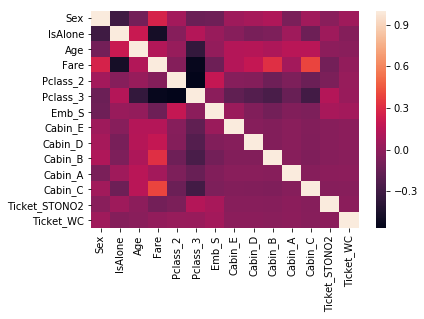

In [8]:
sns.heatmap(X.corr())

In [9]:
help(XGBClassifier.__init__)

Help on function __init__ in module xgboost.sklearn:

__init__(self, max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)
    Initialize self.  See help(type(self)) for accurate signature.



In [10]:
param_grid = {
    'max_depth': [2, 3, 5],
    'learning_rate':[0.05],
    'n_estimators':[100, 200],
    'objective':['binary:logistic'],
#'min_child_weight':[1,2,3],
#    'max_delta_step':[3, 5],
#'gamma':[0,3,10],
#'subsample':[.4, .5, .6, .7, .8],
#'colsample_bytree':[.5, .6, .7, .8],
#'nthread':[4],
#'scale_pos_weight':[1],
#'reg_alpha': [.01, .02, .03, .04],
    'n_jobs': [2],
    'seed': [0],
}

clf = GridSearchCV(XGBClassifier(), param_grid=param_grid, cv=10, scoring='accuracy')
clf.fit(X, y)

print('Best Params: ', clf.best_params_)
print('Best Score: ', clf.best_score_)

Best Params:  {'max_depth': 5, 'n_estimators': 200, 'learning_rate': 0.05, 'objective': 'binary:logistic', 'n_jobs': 2, 'seed': 0}
Best Score:  0.835016835017


# Accuracy Scores (CV=10)
- sex only: 0.786756453423
- sex + pclass: 0.775533108866
- sex + pclass + isalone: 0.791245791246
- sex + pclass + isalone + embark: 0.808080808081 (submit: 0.77990)
- sex + pclass + isalone + embark + age: 0.81593714927
- sex + pclass + isalone + embark + age + fare: 0.840628507295 (submit: 0.78468)

In [11]:
tX = prep(test_df)
tY = clf.predict(tX)

In [12]:
ans = pd.DataFrame(test_df.PassengerId)
ans['Survived'] = tY
ans

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,0
7,899,0
8,900,1
9,901,0


In [13]:
import os
def answer_exists(df):
    for csv in os.listdir('.'):
        if not csv.endswith('.csv'):
            continue
        if not csv.startswith('out'):
            continue
        prev_df = pd.read_csv(csv)
        if (prev_df.Survived != ans.Survived).sum() == 0:
            print("Equivalent to", csv)
            return True

    print("No equivalent answer")
    return False

In [14]:
if not answer_exists(ans):
  ans.to_csv('out-xgb4.csv', index=False)

No equivalent answer
